# 2.4 Runner类介绍

通过上面的实践，我们可以看到，在一个任务上应用机器学习方法的流程基本上包括：数据集构建、模型构建、损失函数定义、优化器、模型训练、模型评价、模型预测等环节。

为了更方便地将上述环节规范化，我们将机器学习模型的基本要素封装成一个**Runner**类。除上述提到的要素外，再加上模型保存、模型加载等功能。

**Runner**类的成员函数定义如下：
* \_\_init\_\_函数：实例化**Runner**类时默认调用，需要传入模型、损失函数、优化器和评价指标等；
* train函数：完成模型训练，指定模型训练需要的训练集和验证集；
* evaluate函数：通过对训练好的模型进行评价，在验证集或测试集上查看模型训练效果；
* predict函数：选取一条数据对训练好的模型进行预测；
* save\_model函数：模型在训练过程和训练结束后需要进行保存；
* load\_model函数：调用加载之前保存的模型。

`Runner`类的框架定义如下：

In [3]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model         # 模型
        self.optimizer = optimizer # 优化器
        self.loss_fn = loss_fn     # 损失函数   
        self.metric = metric       # 评估指标

    # 模型训练
    def train(self, train_dataset, dev_dataset=None, **kwargs):
        pass

    # 模型评价
    def evaluate(self, data_set, **kwargs):
        pass

    # 模型预测
    def predict(self, x, **kwargs):
        pass

    # 模型保存
    def save_model(self, save_path):
        pass

    # 模型加载
    def load_model(self, model_path):
        pass

**Runner**类的流程如**图2.8**所示，可以分为 4 个阶段：
1. 初始化阶段：传入模型、损失函数、优化器和评价指标。
1. 模型训练阶段：基于训练集调用`train()`函数训练模型，基于验证集通过`evaluate()`函数验证模型。通过`save_model()`函数保存模型。
1. 模型评价阶段：基于测试集通过`evaluate()`函数得到指标性能。
1. 模型预测阶段：给定样本，通过`predict()`函数得到该样本标签。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/fdb656daadb349a78560fa464b0de5fa5d63423fc2234adfac48e6ff020a6d60" width=700 ></img></center>

<center>图2.8 Runner类</center>


# 2.5 基于线性回归的波士顿房价预测  

在本节中，我们使用线性回归来对马萨诸塞州波士顿郊区的房屋进行预测。实验流程主要包含如下5个步骤：
* 数据处理：包括数据清洗（缺失值和异常值处理）、数据集划分，以便数据可以被模型正常读取，并具有良好的泛化性;
* 模型构建：定义线性回归模型类；
* 训练配置:训练相关的一些配置，如：优化算法、评价指标等；
* 组装训练框架Runner:`Runner`用于管理模型训练和测试过程；
* 模型训练和测试:利用`Runner`进行模型训练和测试。


## 2.5.1 数据处理

### 2.5.1.1 数据集介绍

本实验使用波士顿房价预测数据集，共506条样本数据，每条样本包含了12种可能影响房价的因素和该类房屋价格的中位数，各字段含义如**表2.1**所示： 

<center>
  
| 字段名   | 类型 | 含义  |
| -------- | -------- | -------- | 
| CRIM	| float | 该镇的人均犯罪率 |
| ZN	| float |占地面积超过25,000平方呎的住宅用地比例|
| INDUS	| float |非零售商业用地比例|
| CHAS	| int   |是否邻近 Charles River 1=邻近；0=不邻近|
| NOX	| float |一氧化氮浓度  | 
| RM	| float |每栋房屋的平均客房数 |
| AGE	| float |1940年之前建成的自用单位比例 |
| DIS	| float |到波士顿5个就业中心的加权距离 |
| RAD	| int   |到径向公路的可达性指数 |
| TAX	| int   |全值财产税率  |
| PTRATIO|float | 学生与教师的比例 |
| LSTAT	| float |低收入人群占比 |
| MEDV	| float |同类房屋价格的中位数 |
  
  </center>
  <center>表2.1 波士顿房价字段含义</center>
  
  预览前5条数据，代码实现如下：

In [4]:
import pandas as pd # 开源数据分析和操作工具

# 利用pandas加载波士顿房价的数据集
data=pd.read_csv("./boston_house_prices.csv")
# 预览前5行数据
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### 2.5.1.2  数据清洗 

对数据集中的缺失值或异常值等情况进行分析和处理，保证数据可以被模型正常读取。

* **缺失值分析**  

通过`isna()`方法判断数据中各元素是否缺失，然后通过`sum()`方法统计每个字段缺失情况，代码实现如下：

In [5]:
# 查看各字段缺失值统计情况
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

从输出结果看，波士顿房价预测数据集中不存在缺失值的情况。

* **异常值处理**

通过箱线图直观的显示数据分布，并观测数据中的异常值。箱线图一般由五个统计值组成：最大值、上四分位、中位数、下四分位和最小值。一般来说，观测到的数据大于最大估计值或者小于最小估计值则判断为异常值，其中
$$
最大估计值 = 上四分位 + 1.5 * (上四分位 - 下四分位)\\
最小估计值=下四分位 - 1.5 * (上四分位 - 下四分位)
$$

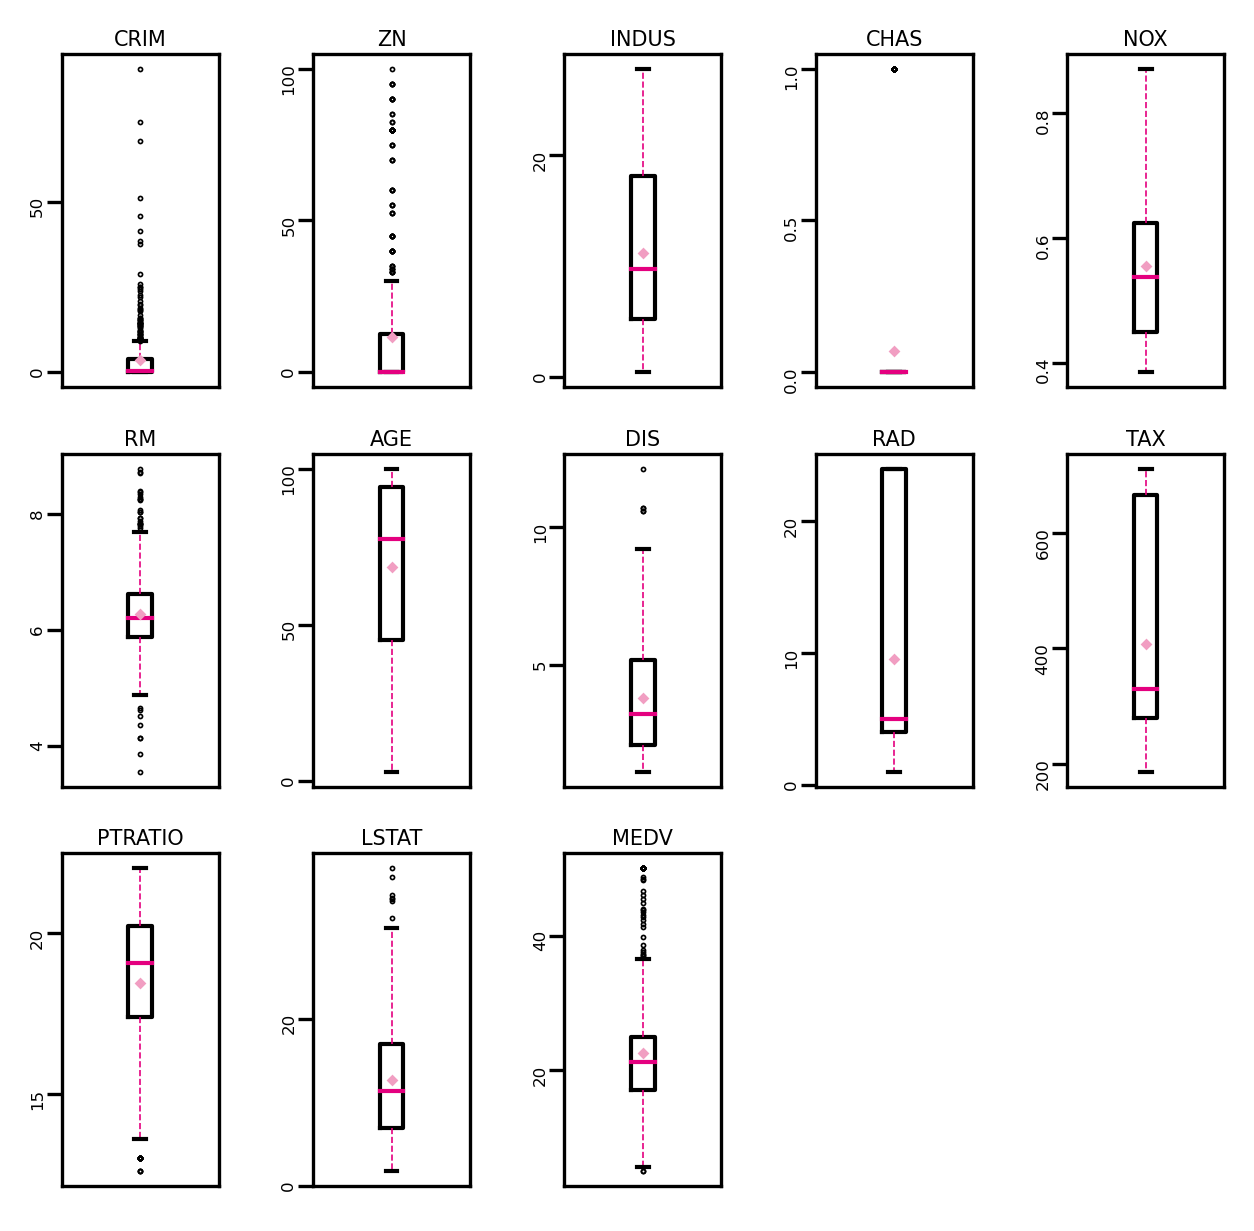

In [6]:
import matplotlib.pyplot as plt # 可视化工具

# 箱线图查看异常值分布
def boxplot(data, fig_name):
    # 绘制每个属性的箱线图
    data_col = list(data.columns)
    
    # 连续画几个图片
    plt.figure(figsize=(5, 5), dpi=300)
    # 子图调整
    plt.subplots_adjust(wspace=0.6)
    # 每个特征画一个箱线图
    for i, col_name in enumerate(data_col):
        plt.subplot(3, 5, i+1)
        # 画箱线图
        plt.boxplot(data[col_name], 
                    showmeans=True, 
                    meanprops={"markersize":1,"marker":"D","markeredgecolor":'#f19ec2'}, # 均值的属性
                    medianprops={"color":'#e4007f'}, # 中位数线的属性
                    whiskerprops={"color":'#e4007f', "linewidth":0.4, 'linestyle':"--"},
                    flierprops={"markersize":0.4},
                    ) 
        # 图名
        plt.title(col_name, fontdict={"size":5}, pad=2)
        # y方向刻度
        plt.yticks(fontsize=4, rotation=90)
        plt.tick_params(pad=0.5)
        # x方向刻度
        plt.xticks([])
    plt.savefig(fig_name)
    plt.show()

boxplot(data, 'ml-vis5.pdf')

**图2.4**是箱线图的一个示例，可对照查看具体含义。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/242350bbd60d4afbbedc62bdc5579a54fa8e375d2481408d9be77069e578f39e" width=700 ></img></center>
<center>图2.4 箱线图示例</center>

从输出结果看，数据中存在较多的异常值（图中上下边缘以外的空心小圆圈）。

使用四分位值筛选出箱线图中分布的异常值，并将这些数据视为噪声，其将被临界值取代，代码实现如下：

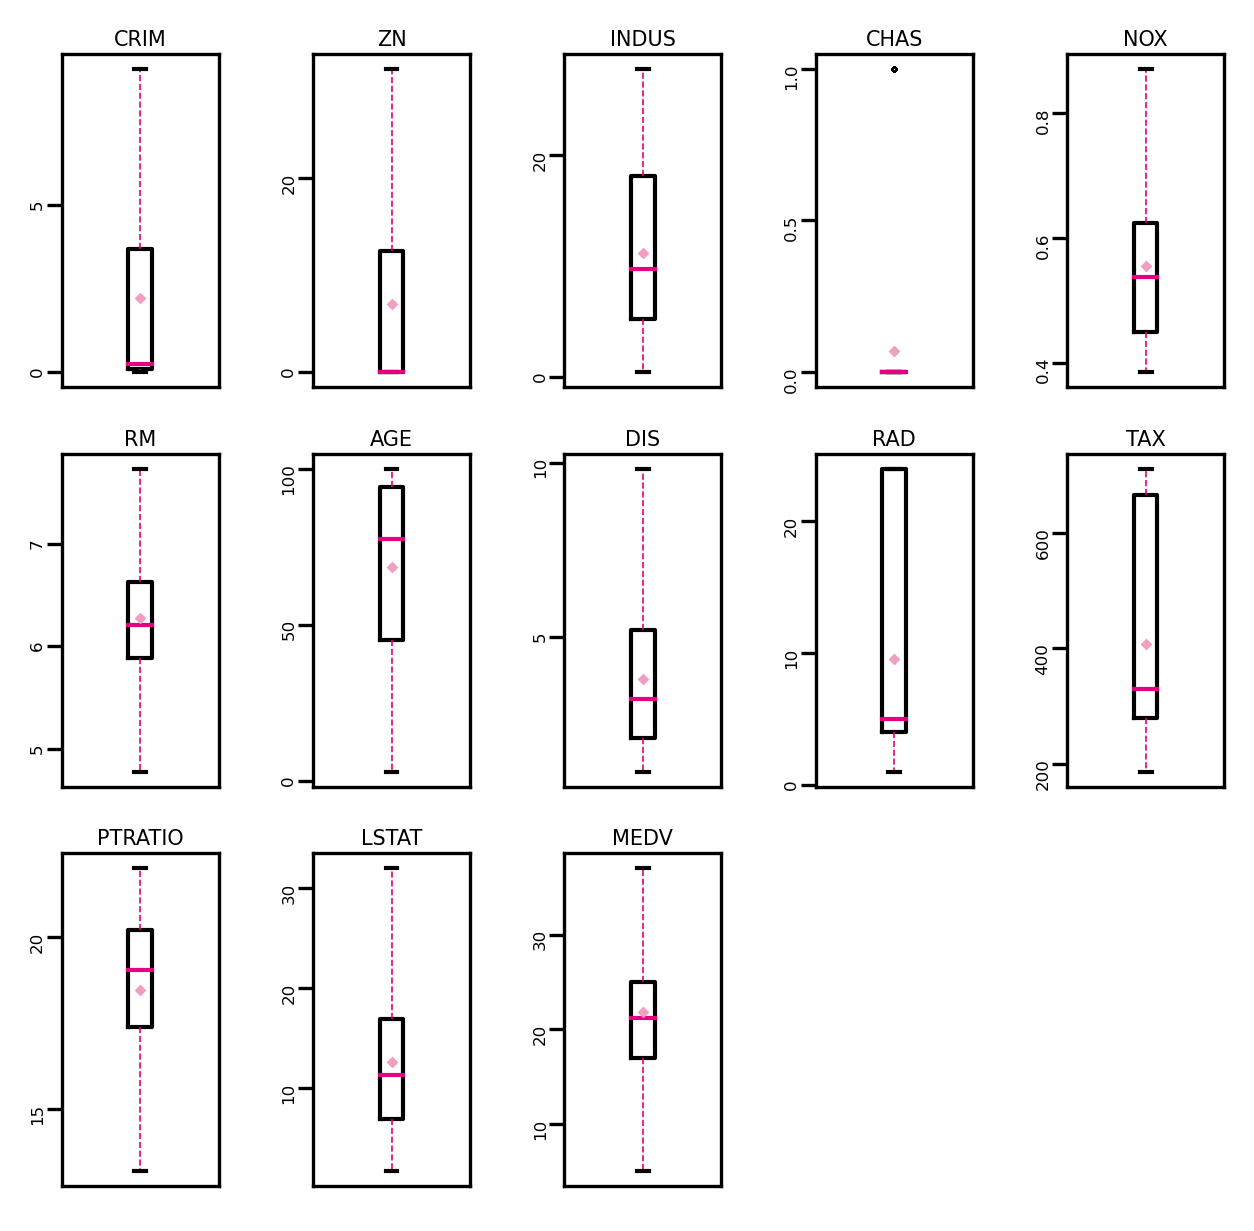

In [7]:
# 四分位处理异常值
num_features=data.select_dtypes(exclude=['object','bool']).columns.tolist()

for feature in num_features:
    if feature =='CHAS':
        continue
    
    Q1  = data[feature].quantile(q=0.25) # 下四分位
    Q3  = data[feature].quantile(q=0.75) # 上四分位
    
    IQR = Q3-Q1 
    top = Q3+1.5*IQR # 最大估计值
    bot = Q1-1.5*IQR # 最小估计值
    values=data[feature].values
    values[values > top] = top # 临界值取代噪声
    values[values < bot] = bot # 临界值取代噪声
    data[feature] = values.astype(data[feature].dtypes)

# 再次查看箱线图，异常值已被临界值替换（数据量较多或本身异常值较少时，箱线图展示会不容易体现出来）
boxplot(data, 'ml-vis6.pdf')

从输出结果看，经过异常值处理后，箱线图中异常值得到了改善。

### 2.5.1.3 数据集划分 

由于本实验比较简单，将数据集划分为两份：训练集和测试集，不包括验证集。

具体代码如下：

In [8]:
import paddle

paddle.seed(10)

# 划分训练集和测试集
def train_test_split(X, y, train_percent=0.8):
    n = len(X)
    shuffled_indices = paddle.randperm(n) # 返回一个数值在0到n-1、随机排列的1-D Tensor
    train_set_size = int(n*train_percent)
    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]

    X = X.values
    y = y.values

    X_train=X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test 


X = data.drop(['MEDV'], axis=1)
y = data['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X,y)# X_train每一行是个样本，shape[N,D]


### 2.5.1.4 特征工程
为了消除纲量对数据特征之间影响，在模型训练前，需要对特征数据进行归一化处理，将数据缩放到[0, 1]区间内，使得不同特征之间具有可比性。

代码实现如下：

In [9]:
import paddle

X_train = paddle.to_tensor(X_train,dtype='float32')
X_test = paddle.to_tensor(X_test,dtype='float32')
y_train = paddle.to_tensor(y_train,dtype='float32')
y_test = paddle.to_tensor(y_test,dtype='float32')

X_min = paddle.min(X_train,axis=0)
X_max = paddle.max(X_train,axis=0)

X_train = (X_train-X_min)/(X_max-X_min)

X_test  = (X_test-X_min)/(X_max-X_min)

# 训练集构造
train_dataset=(X_train,y_train)
# 测试集构造
test_dataset=(X_test,y_test)

## 2.5.2 模型构建

实例化一个线性回归模型，特征维度为 12:

In [10]:
from nndl.op import Linear

# 模型实例化
input_size = 12
model=Linear(input_size)

## 2.5.3 完善Runner类
模型定义好后，围绕模型需要配置损失函数、优化器、评估、测试等信息，以及模型相关的一些其他信息（如模型存储路径等）。

在本章中使用的**Runner**类为V1版本。其中训练过程通过直接求解解析解的方式得到模型参数，没有模型优化及计算损失函数过程，模型训练结束后保存模型参数。

训练配置中定义:
* 训练环境，如GPU还是CPU，本案例不涉及；
* 优化器，本案例不涉及；
* 损失函数，本案例通过平方损失函数得到模型参数的解析解；
* 评估指标，本案例利用MSE评估模型效果。


在测试集上使用MSE对模型性能进行评估。本案例利用飞桨框架提供的[MSELoss API](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/MSELoss_cn.html)实现。

In [11]:
import paddle.nn as nn
mse_loss = nn.MSELoss()

具体实现如下：

In [12]:
import paddle
import os
from nndl.opitimizer import optimizer_lsm

class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        # 优化器和损失函数为None,不再关注

        # 模型
        self.model=model
        # 评估指标
        self.metric = metric
        # 优化器
        self.optimizer = optimizer
    
    def train(self,dataset,reg_lambda,model_dir):
        X,y = dataset
        self.optimizer(self.model,X,y,reg_lambda)

        # 保存模型
        self.save_model(model_dir)
    
    def evaluate(self, dataset, **kwargs):
        X,y = dataset

        y_pred = self.model(X)
        result = self.metric(y_pred, y)

        return result

    def predict(self, X, **kwargs):
        return self.model(X)
    
    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        params_saved_path = os.path.join(model_dir,'params.pdtensor')
        paddle.save(model.params,params_saved_path)

    def load_model(self, model_dir):
        params_saved_path = os.path.join(model_dir,'params.pdtensor')
        self.model.params=paddle.load(params_saved_path)

optimizer = optimizer_lsm

# 实例化Runner
runner = Runner(model, optimizer=optimizer,loss_fn=None, metric=mse_loss)

## 2.5.4 模型训练

在组装完成`Runner`之后，我们将开始进行模型训练、评估和测试。首先，我们先实例化`Runner`，然后开始进行装配训练环境，接下来就可以开始训练了，相关代码如下：

In [13]:
# 模型保存文件夹
saved_dir = '/home/aistudio/work/models'

# 启动训练
runner.train(train_dataset,reg_lambda=0,model_dir=saved_dir)

打印出训练得到的权重：

In [14]:
columns_list = data.columns.to_list()
weights = runner.model.params['w'].tolist()
b = runner.model.params['b'].item()

for i in range(len(weights)):
    print(columns_list[i],"weight:",weights[i])

print("b:",b)


CRIM weight: -5.7056989669799805
ZN weight: 1.180450677871704
INDUS weight: -0.9549108147621155
CHAS weight: 1.917398452758789
NOX weight: -5.87213134765625
RM weight: 9.139520645141602
AGE weight: -0.6965242624282837
DIS weight: -9.788663864135742
RAD weight: 7.860557556152344
TAX weight: -5.2367401123046875
PTRATIO weight: -6.668805122375488
LSTAT weight: -14.417865753173828
b: 32.554203033447266


从输出结果看，CRIM、PTRATIO等的权重为负数，表示该镇的人均犯罪率与房价负相关，学生与教师比例越大，房价越低。RAD和CHAS等为正，表示到径向公路的可达性指数越高，房价越高；临近Charles River房价高。

## 2.5.5 模型测试

加载训练好的模型参数，在测试集上得到模型的MSE指标。

In [15]:
# 加载模型权重
runner.load_model(saved_dir)

mse = runner.evaluate(test_dataset)
print('MSE:', mse.item())

MSE: 17.047901153564453


## 2.5.6 模型预测

使用`Runner`中`load_model`函数加载保存好的模型，使用`predict`进行模型预测，代码实现如下：

In [16]:
runner.load_model(saved_dir)
pred = runner.predict(X_test[:1])
print("真实房价：",y_test[:1].item())
print("预测的房价：",pred.item())

真实房价： 21.399999618530273
预测的房价： 24.058422088623047


从输出结果看，预测房价接近真实房价。